# Artificial Data

This notebook shows how to use the models on artificially generated time series data.

In [1]:
import os
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from context import anomaly_detection
# data utils
from anomaly_detection.utils.data_utils import preprocess, get_timeseries_from_array, generate_multivariate_time_series_data_with_anomalies
from anomaly_detection.utils.plotting import plot_anomaly_scores
# performance metrics
from anomaly_detection.utils.metrics import find_best_anomaly_threshold, get_perf_metrics, find_best_f1_score, get_anomaly_root_cause_hitrate_perf, get_anomaly_root_cause_hitrate_perf_v2

## Generate synthetic data
* Number of features (dimensions) = 20
* Each anomaly is visible in 1-3 features (dimensions)
* Number of randomly generated anomalies = 40
* Number of observations = 80000
    * First half is used for training, the last half for testing
* Anomalies start occurring after 40000 index (first half of the data is anomaly free, i.e. "normal")

In [2]:
x, anomalies = generate_multivariate_time_series_data_with_anomalies(
    n_dim=20, 
    n_max_anomaly_dims=3, 
    random_state=2, # use for reproducibly, change to generate different set (to do the experiment multiple times with new data)
    n_samples=80000, 
    n_anomalies=40, 
    anomalies_start_idx=40000,
    combined_seasonality=None,
    noise_level=0.3)

## Visualize a section of the artificial data and anomalies

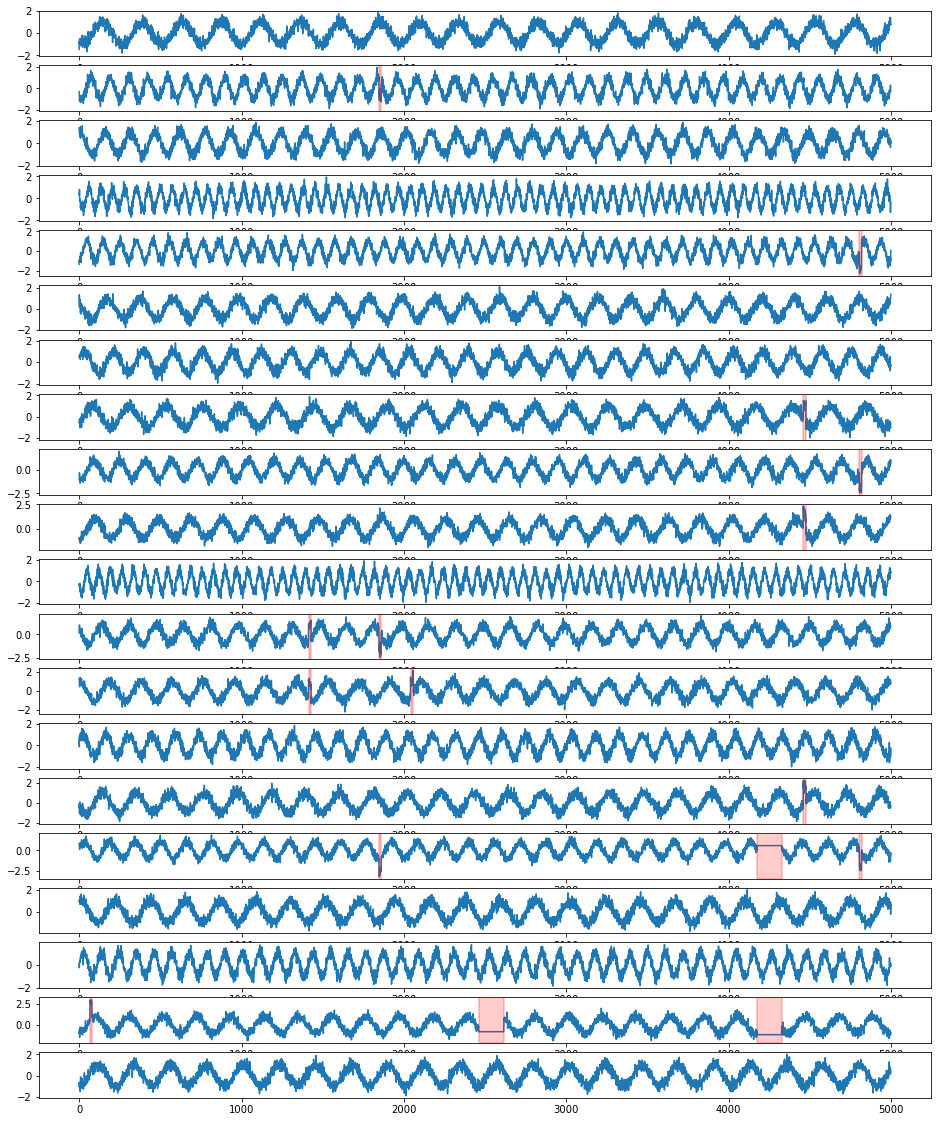

In [3]:
s = 40000 # section start idx
e = 45000 # section end idx

fig = plt.figure(figsize=(16, 20))
for dim in range(x.shape[1]):
    plt.subplot(x.shape[1], 1, dim + 1)
    plt.plot(x[:, dim][s:e])
    ax = plt.gca()
    for anomaly in anomalies:
        if dim in anomaly['dims'] and anomaly['a_start'] < e and anomaly['a_start'] > s:
            ax.axvspan(anomaly['a_start'] - s, anomaly['a_end'] - s, alpha=0.2, color='red', linewidth=2, zorder=100)
plt.show()

## Preprocess data

Split data into train and test sets.

**Train set:**
* `x_train`: Train data
* `y_train`: Train labels (1 = anomaly, 0 = normal)

**Test set:**
* `x_test`: Test data
* `y_test`: Test labels (1 = anomaly, 0 = normal)

We fit a min max scaler using train data, and then transform both train and test data values into [0, 1] range.

**Root causes**

Root causes are stored in `y_test_root_causes` dict where key is the sample index in `x_test` and value is an array of dimensions that contribute to the anomaly at that sample index.

In [4]:
y_true = np.zeros(len(x))
anomalous_indices = np.concatenate(list(map(lambda anomaly: np.arange(anomaly['a_start'], min(anomaly['a_end'] + 50, len(x) - 1)), anomalies)))
y_true[anomalous_indices] = 1
test_set_begin_idx = 40000
x_train = x[:test_set_begin_idx]
y_train = y_true[:test_set_begin_idx]
x_test = x[test_set_begin_idx:]
y_test = y_true[test_set_begin_idx:]

print(x_train.shape)
print(x_test.shape)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

y_test_root_causes = dict()
for a in anomalies:
    for i in range(a['a_start'], a['a_end'] + 1):
        y_test_root_causes[i - test_set_begin_idx] = a['dims']

(40000, 20)
(40000, 20)


## Evaluation

Next, we begin testing different anomaly detection methods on the artificial data and report their performance.

In [5]:
# Skip n first data points of test set when scoring anomaly detection performance
# We do this because window based anomaly detection methods cannot provide anomaly scores for the data points within the
# initial window.
skip_n_first = 100

### MEWMA - Multivariate exponentially Weighted Moving Average

MEWMA control chart, a commonly applied multivariate method in statistical process control (SPC). Assumes the data to be independent.

Hyperparameters:
* Weighting factor 0-1.

t {'f1-score': 0.2909090485950471, 'precision': 0.49999999687499996, 'recall': 0.20512820460223535, 'TP': 8, 'TN': 35633, 'FP': 8, 'FN': 31, 'detection_latency': 21.624999729687506}
th 95.91189173997306


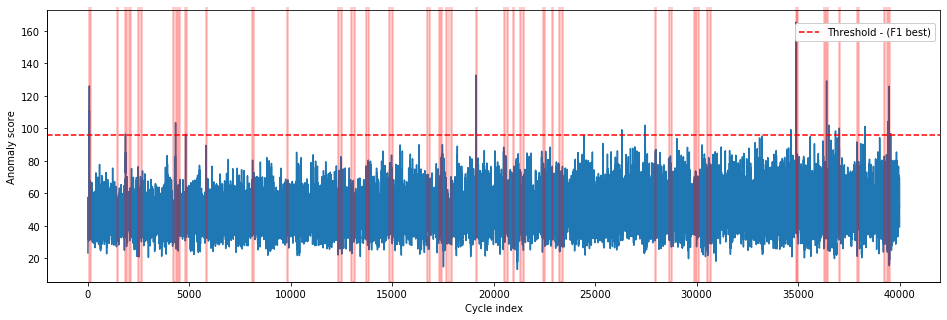

In [6]:
from anomaly_detection.models.mewma.mewma import MEWMA
mewma = MEWMA(0.6) # try different weighting factors to find optimal for your data
mewma.fit(x_train)
x_test_scores = mewma.predict(x_test)
best_threshold = find_best_f1_score(y_test, x_test_scores, threshold_search_step_size=0.1, single_score_per_labeled_sequence=True, skip_n_first=skip_n_first)
plot_anomaly_scores(x_test_scores, y_test, best_threshold)

### VAR-T2 - Vector Autoregression + Hotelling's T-Squared

Vector autoregression models the serial correlation in the data, and Hotelling's T2 statistic is then used to detect anomalies in residuals between the predicted and observed values of the data.

Hyperparameters:

* Number of lags, chosen with AIC (specify max lags to test)

<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 86, BIC -> 26, FPE -> 86, HQIC -> 46>
Using 86 based on aic criterion
t {'f1-score': 0.8169013566355912, 'precision': 0.9062499971679687, 'recall': 0.7435897416831032, 'TP': 29, 'TN': 35638, 'FP': 3, 'FN': 10, 'detection_latency': 25.999999910344826}
th 62.92327631406169


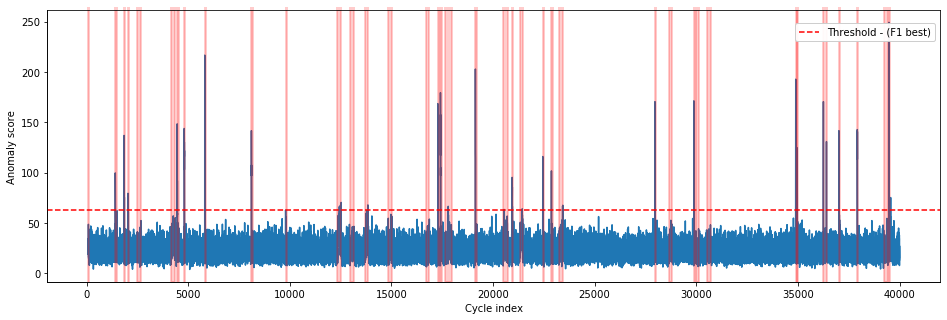

In [7]:
from anomaly_detection.models.vector_autoregression.model import VAR_AnomalyDetector
var_model = VAR_AnomalyDetector()
var_model.fit(x_train, verbose=True, max_lags=100, max_num_differencing=0, missing='drop', order_selection_criteria='aic')
_, x_test_scores = var_model.predict(x_test)
best_threshold = find_best_f1_score(y_test, x_test_scores, threshold_search_step_size=0.5, single_score_per_labeled_sequence=True, skip_n_first=skip_n_first)
plot_anomaly_scores(x_test_scores, y_test, best_threshold)

### OC-SVM - One-Class Support Vector Machine

Fit using normal training data, predict the whole test data.

Hyperparameters:
* Kernel = Radial basis function (rbf) (default)
* Gamma = 'scale' - Kernel coefficient (default)
* Tol = Tolerance for stopping criterion. 1e-3 (default)
* Nu = An upper bound on the fraction of training errors and a lower bound of the fraction of support vectors. Should be in the interval (0, 1]. By default 0.5 will be taken.

t {'f1-score': 0.43636359352066484, 'precision': 0.7499999953125, 'recall': 0.30769230690335303, 'TP': 12, 'TN': 35637, 'FP': 4, 'FN': 27, 'detection_latency': 7.7499999354166675}
th -18042.60131951978


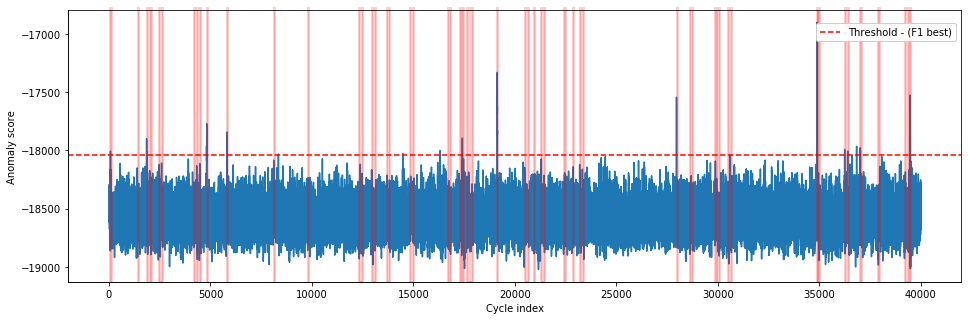

In [24]:
from sklearn.svm import OneClassSVM
clf = OneClassSVM(gamma='auto').fit(x_train)
x_test_scores = -clf.score_samples(x_test) # flip scores so that higher means more anomalous
best_threshold = find_best_f1_score(y_test, x_test_scores, threshold_search_step_size=5, single_score_per_labeled_sequence=True, skip_n_first=skip_n_first)
plot_anomaly_scores(x_test_scores, y_test, best_threshold)

### LODA - Lightweight On-Line Detector of Anomalies

Test both offline and online learning setups.

LODA with online prediction - uses only test set and learns from the data stream from each new input.

Two windowing choises:
* Streaming window
* Two window

Hyperparameters:
* Number of estimators (histograms)
* Number of bins (in each histogram)

**LODA - offline training**

Optimal number of histograms 81
t {'f1-score': 0.40740736577503817, 'precision': 0.7333333284444445, 'recall': 0.2820512813280736, 'TP': 11, 'TN': 35705, 'FP': 4, 'FN': 28, 'detection_latency': 0.7272727206611571}
th 1.5434994621171727


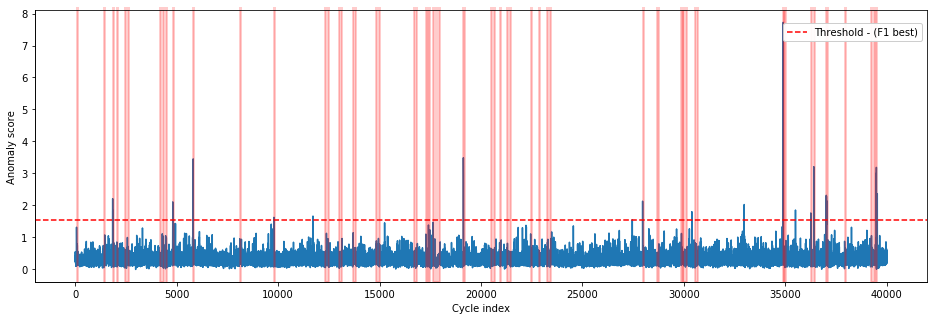

In [27]:
from anomaly_detection.models.loda.loda import LODA
loda = LODA(n_estimators=0.01, bins='auto', random_state=1, q=0.0005, verbose=1)
loda.fit(x_train)
x_test_scores = loda.score_samples(x_test)
x_test_scores = -x_test_scores # have to flip it since the scores are log-likelihood but we want higher = more anomalous = NLL
best_threshold = find_best_f1_score(y_test, x_test_scores, threshold_search_step_size=0.01)
plot_anomaly_scores(x_test_scores, y_test, best_threshold)

t {'f1-score': 0.6060605558769551, 'precision': 0.7407407379972565, 'recall': 0.5128205115055884, 'TP': 20, 'TN': 35702, 'FP': 7, 'FN': 19, 'detection_latency': 17.84999991075}
th 0.9611491518126303
HitRate@100%: 0.5416666666666667
HitRate@150%: 0.575


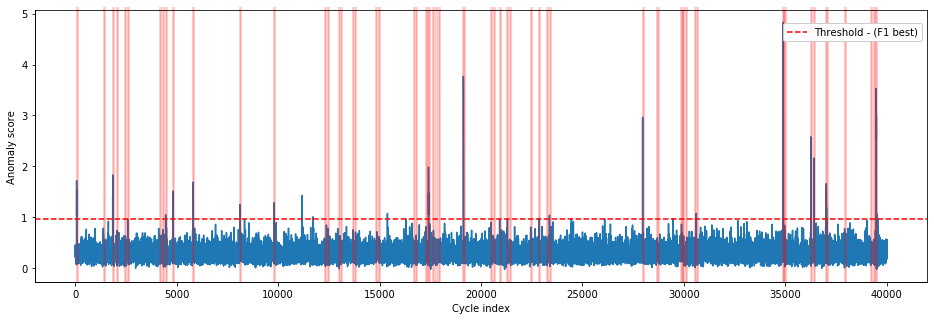

In [36]:
from anomaly_detection.models.loda.loda import LODA
loda = LODA(n_estimators=400, bins=60, random_state=1, q=0.0005, verbose=1)
loda.fit(x_train)
x_test_scores = loda.score_samples(x_test)
x_test_scores = -x_test_scores # have to flip it since the scores are log-likelihood but we want higher = more anomalous = NLL
best_threshold = find_best_f1_score(y_test, x_test_scores, threshold_search_step_size=0.01)
# anomaly interpretation performance
y_test_pred_best = (x_test_scores > best_threshold).astype(int)
x_test_feature_scores = loda.score_features(x_test)
print('HitRate@100%:', get_anomaly_root_cause_hitrate_perf_v2(y_test, y_test_pred_best, x_test_scores, x_test_feature_scores, y_test_root_causes, p=100))
print('HitRate@150%:', get_anomaly_root_cause_hitrate_perf_v2(y_test, y_test_pred_best, x_test_scores, x_test_feature_scores, y_test_root_causes, p=150))
# plot anomaly scores
plot_anomaly_scores(x_test_scores, y_test, best_threshold)

**LODA - online training**

t {'f1-score': 0.4827585749702774, 'precision': 0.7368421013850416, 'recall': 0.35897435805391187, 'TP': 14, 'TN': 35704, 'FP': 5, 'FN': 25, 'detection_latency': 15.285714176530613}
th 2.060099502917525
HitRate@100%: 0.6547619047619048
HitRate@150%: 0.6785714285714286


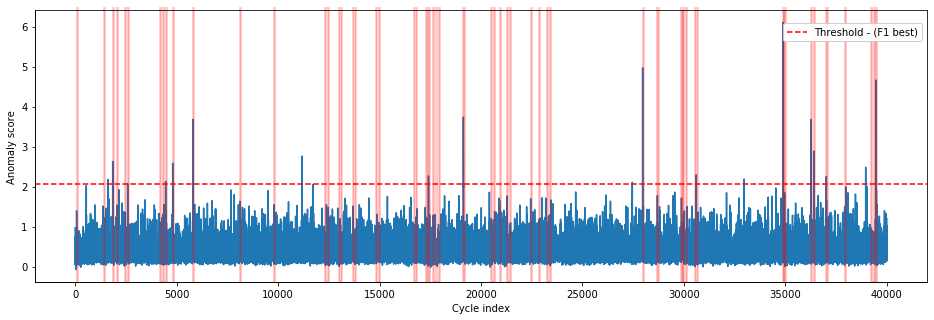

In [29]:
from anomaly_detection.models.loda.loda import LODA
loda = LODA(n_estimators=500, bins=20, random_state=1, q=0.0005, verbose=1)
y_test_pred, x_test_scores, x_test_feature_scores = loda.online_predict(x_test, win_size=500)
x_test_scores = -x_test_scores # have to flip it since the scores are log-likelihood but we want higher = more anomalous
best_threshold = find_best_f1_score(y_test, x_test_scores, threshold_search_step_size=0.01, single_score_per_labeled_sequence=True)
# anomaly interpretation performance
y_test_pred_best = (x_test_scores > best_threshold).astype(int)
print('HitRate@100%:', get_anomaly_root_cause_hitrate_perf_v2(y_test, y_test_pred_best, x_test_scores, x_test_feature_scores, y_test_root_causes, p=100))
print('HitRate@150%:', get_anomaly_root_cause_hitrate_perf_v2(y_test, y_test_pred_best, x_test_scores, x_test_feature_scores, y_test_root_causes, p=150))
# plot anomaly scores
plot_anomaly_scores(x_test_scores, y_test, best_threshold)

### EncDec-AD - LSTM Encoder-Decoder

In [18]:
from anomaly_detection.models.encdec_ad.encdec_ad import EncDecAD

model = EncDecAD(input_dim, 
                 n_timesteps, 
                 rnn_num_hidden=128,
                 rnn_layer='LSTM',
                 bidirectional=False,
                 allow_cudnn_kernel=True,
                 optimizer=tf.keras.optimizers.Adam())

# print model architecture
print(model.model.summary())

# fit model on the training data
es_cb = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)
history = model.fit(train_ds, validation_data=valid_ds, epochs=50, callbacks=[es_cb])

Model: "enc_dec_ae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 100, 20)]    0                                            
__________________________________________________________________________________________________
tf_op_layer_Shape_2 (TensorFlow [(3,)]               0           encoder_input[0][0]              
__________________________________________________________________________________________________
tf_op_layer_strided_slice_2 (Te [()]                 0           tf_op_layer_Shape_2[0][0]        
__________________________________________________________________________________________________
tf_op_layer_Pack_2 (TensorFlowO [(2,)]               0           tf_op_layer_strided_slice_2[0][0]
_________________________________________________________________________________________

109/109 [==============================] - 12s 110ms/step - loss: 0.0487 - val_loss: 0.0336
Epoch 2/50
109/109 [==============================] - 9s 82ms/step - loss: 0.0327 - val_loss: 0.0316
Epoch 3/50
109/109 [==============================] - 9s 85ms/step - loss: 0.0293 - val_loss: 0.0271
Epoch 4/50
109/109 [==============================] - 9s 85ms/step - loss: 0.0243 - val_loss: 0.0229
Epoch 5/50
109/109 [==============================] - 9s 86ms/step - loss: 0.0199 - val_loss: 0.0190
Epoch 6/50
109/109 [==============================] - 9s 86ms/step - loss: 0.0162 - val_loss: 0.0157
Epoch 7/50
109/109 [==============================] - 9s 85ms/step - loss: 0.0130 - val_loss: 0.0129s: 0.013
Epoch 8/50
109/109 [==============================] - 9s 85ms/step - loss: 0.0107 - val_loss: 0.0114
Epoch 9/50
109/109 [==============================] - 10s 87ms/step - loss: 0.0088 - val_loss: 0.0089
Epoch 10/50
109/109 [==============================] - 9s 87ms/step - loss: 0.0076 - val_lo

t {'f1-score': 0.7999999495384643, 'precision': 0.9999999961538462, 'recall': 0.6666666649572649, 'TP': 26, 'TN': 35641, 'FP': 0, 'FN': 13, 'detection_latency': 20.384615306213018}
th 83.65009655372141


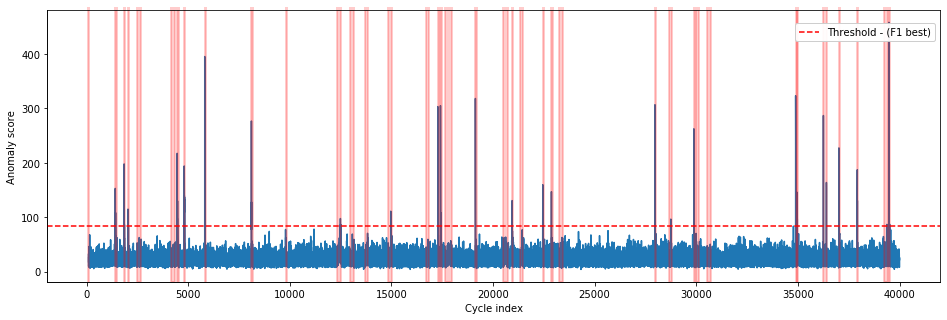

In [19]:
# use small enough batch size to prevent OOM
x_test_scores = model.get_anomaly_score(x_test, batch_size=batch_size)
best_threshold = find_best_f1_score(y_test, x_test_scores, threshold_search_step_size=0.5, threshold_search_end=np.percentile(x_test_scores, 99.95), single_score_per_labeled_sequence=True, skip_n_first=skip_n_first)
# plot anomaly scores
plot_anomaly_scores(x_test_scores, y_test, best_threshold)

#### Visualize EncDec-AD reconstructions of the data

(39901, 100, 20)


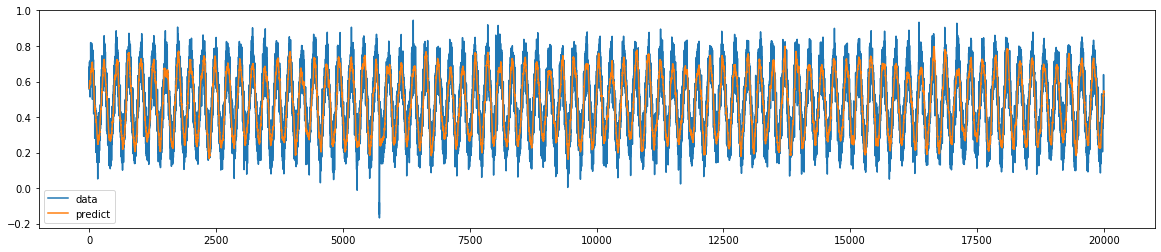

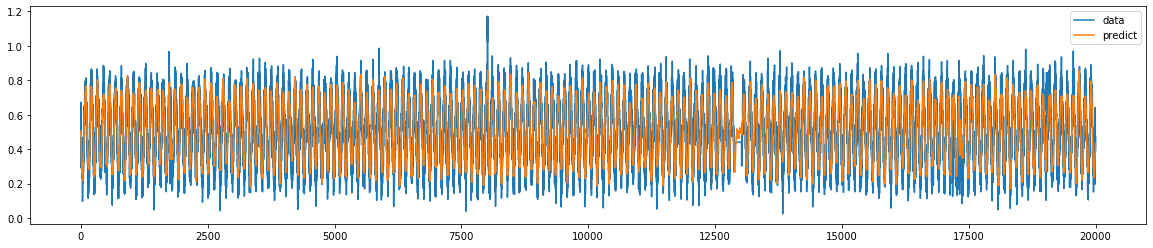

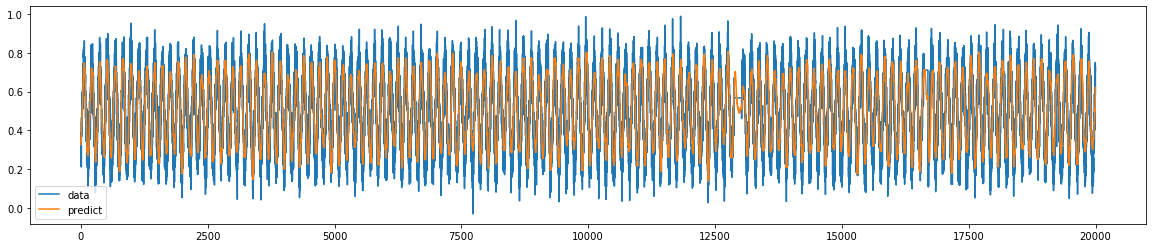

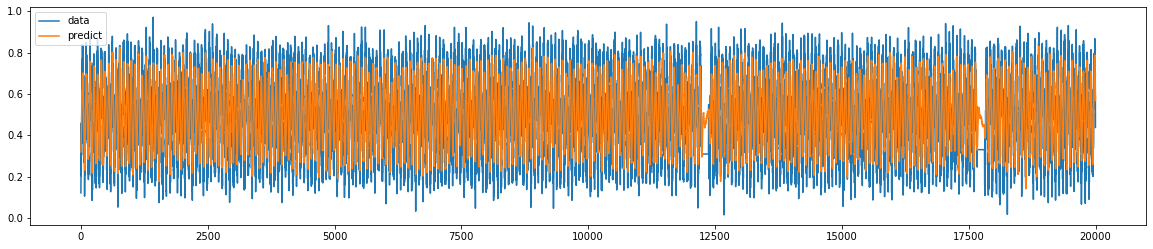

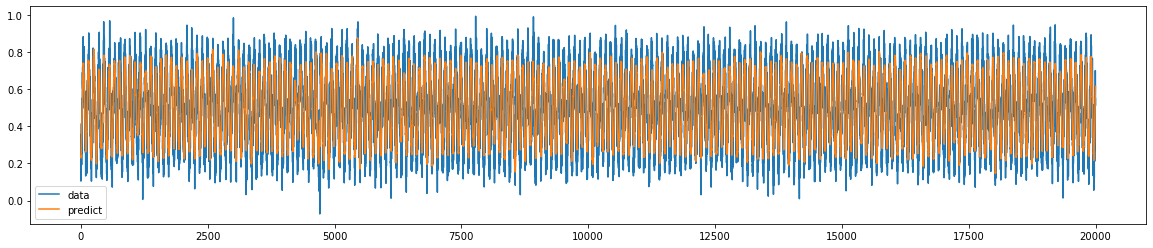

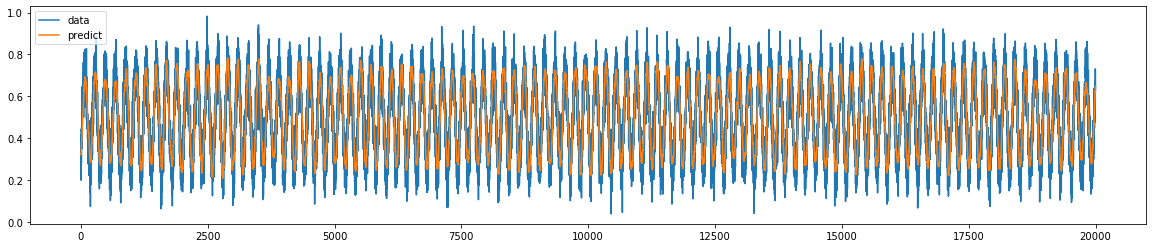

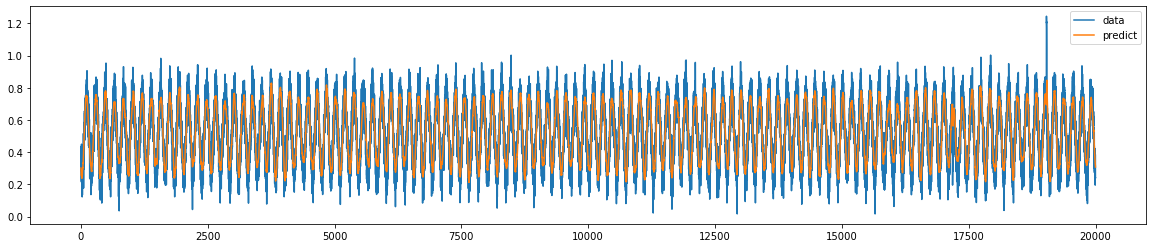

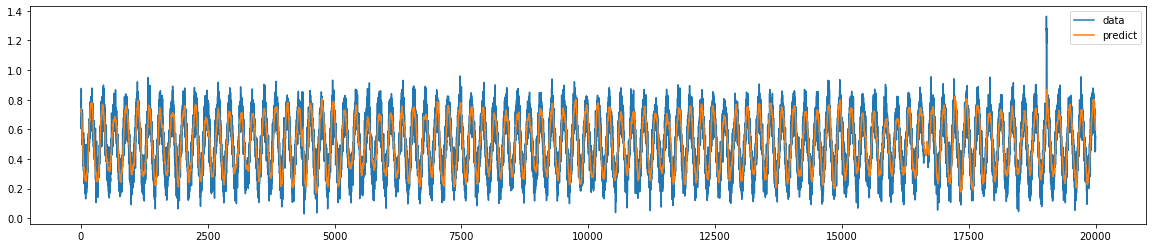

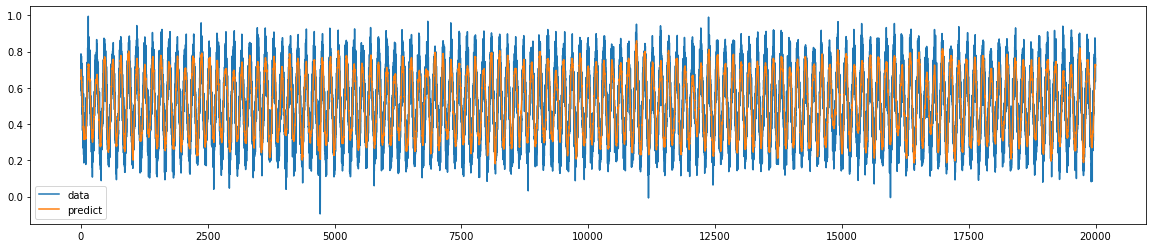

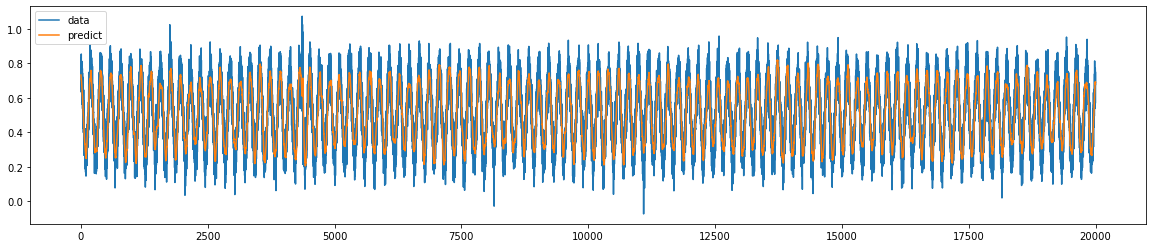

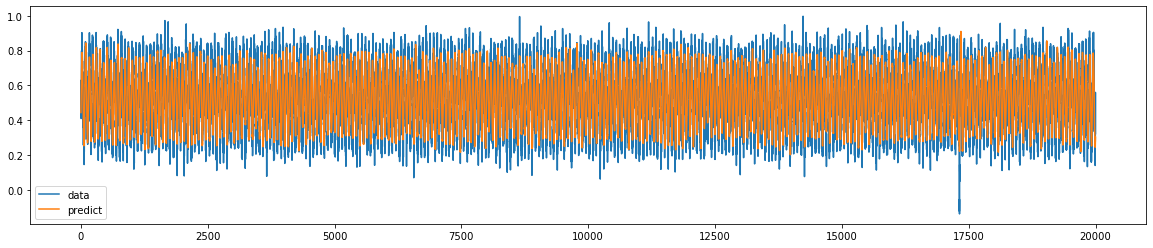

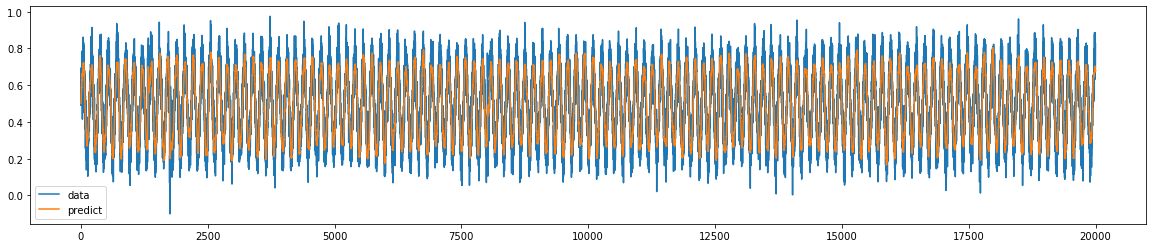

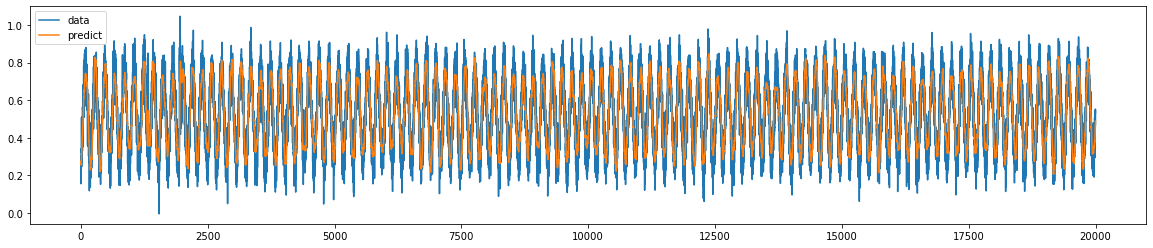

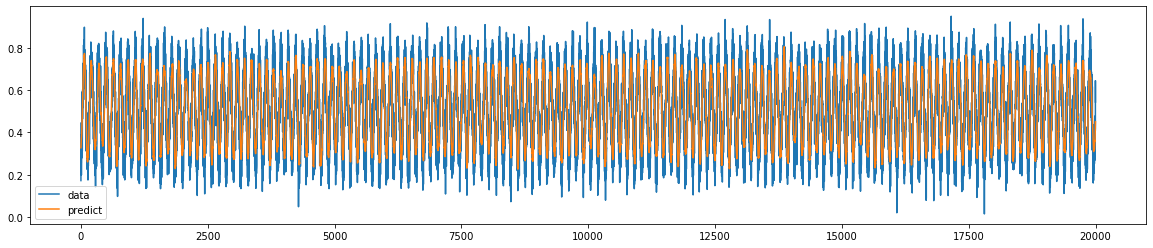

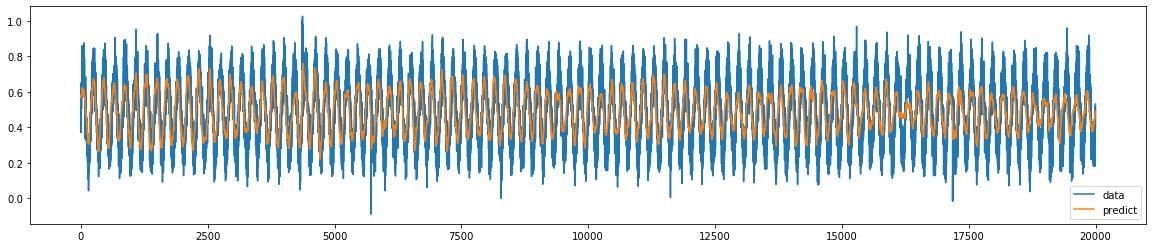

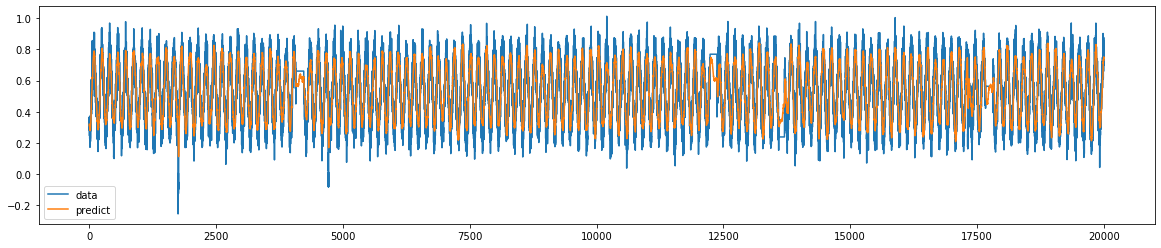

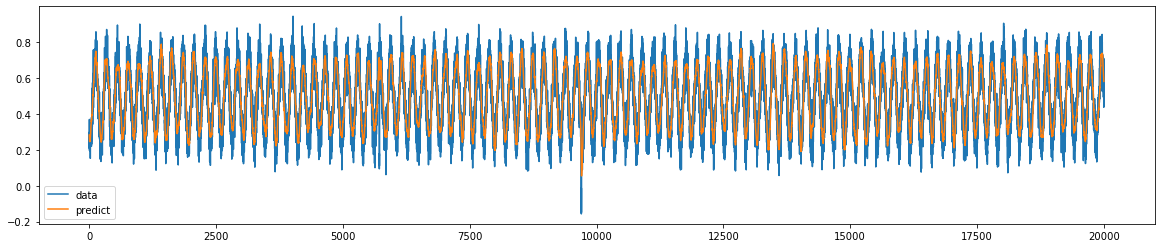

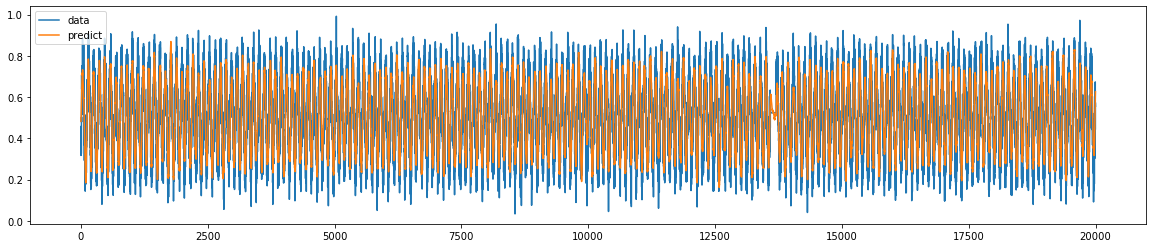

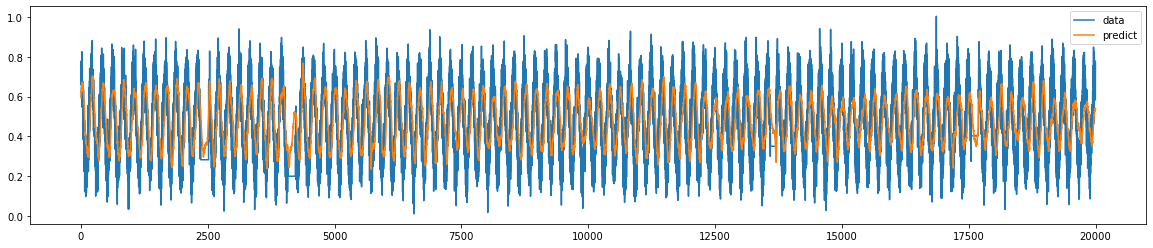

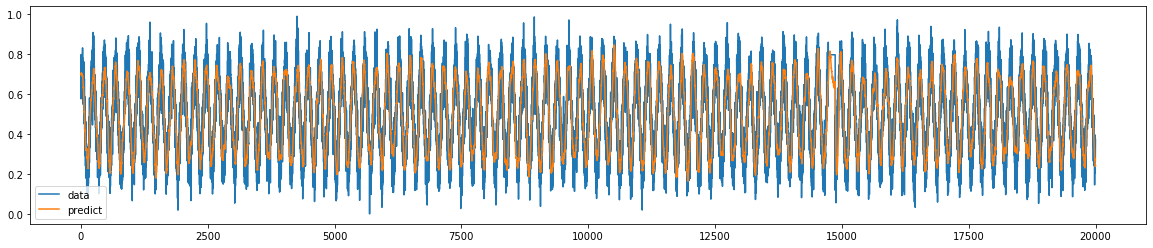

In [144]:
timesteps = n_timesteps
x_test_timeseries = get_timeseries_from_array(x_test, timesteps)
print(x_test_timeseries.shape)
x_test_pred = model.predict(x_test_timeseries, batch_size=batch_size)
time_window_idx=-1
num_data_points=20000
for i in range(0, x_test_timeseries.shape[-1]):  # plot each feature in a separate plot
    plt.figure(figsize=(20, 4))
    plt.plot(x_test_timeseries[:, time_window_idx, i][:num_data_points], label='data')
    plt.plot(x_test_pred[:, time_window_idx, i][:num_data_points], label='predict')
    plt.legend()
    plt.show()

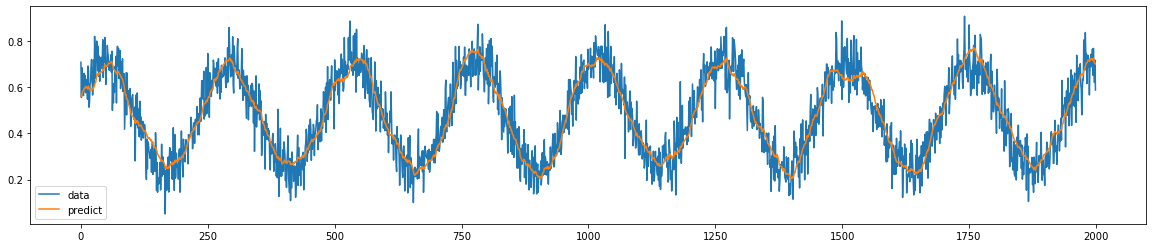

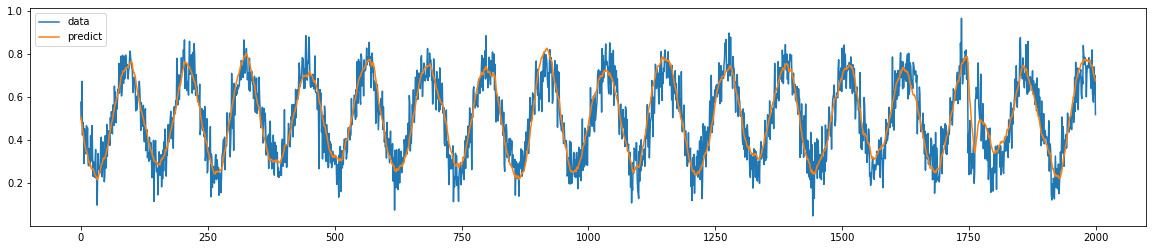

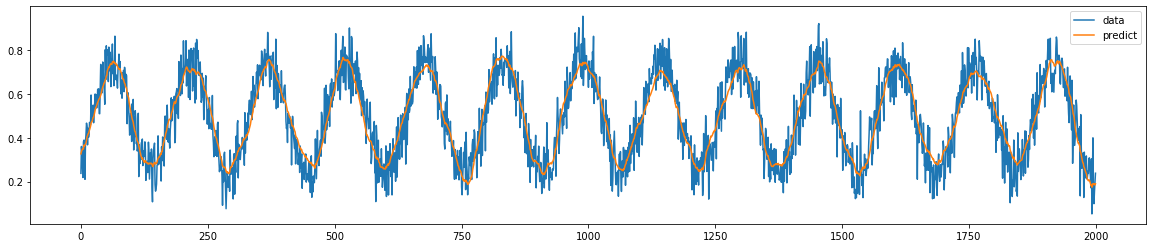

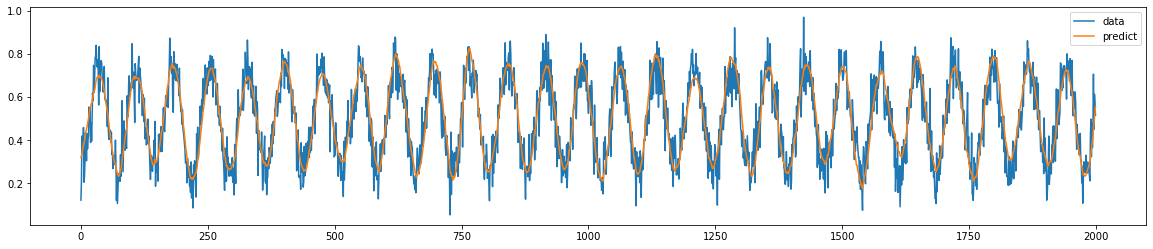

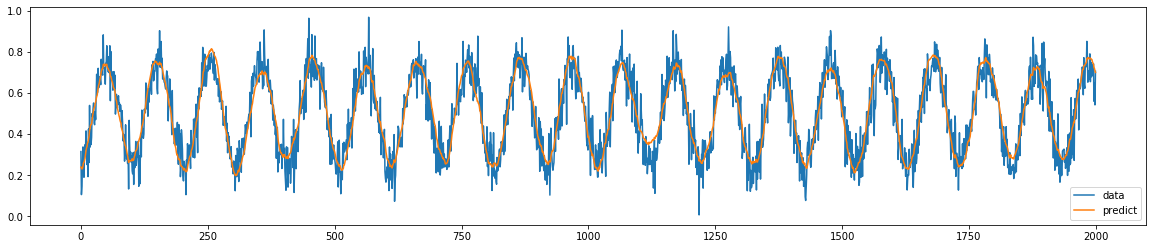

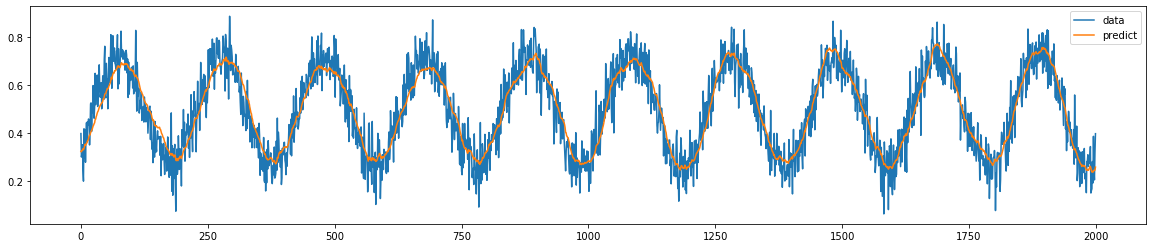

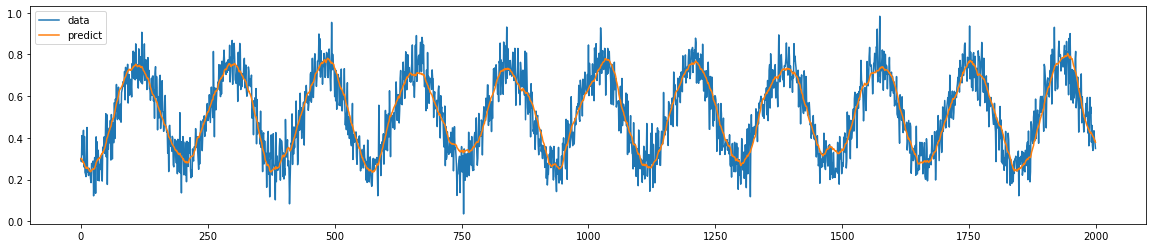

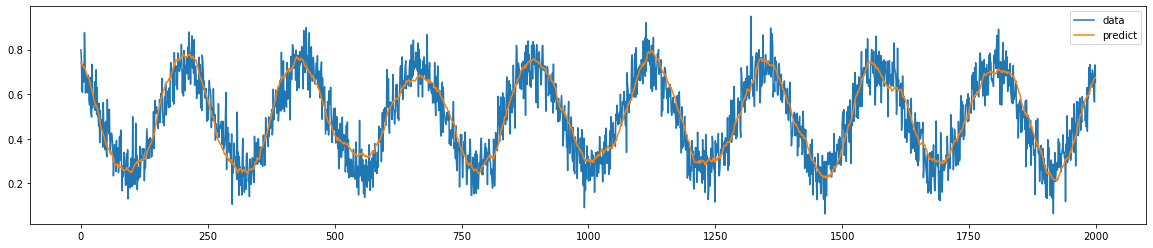

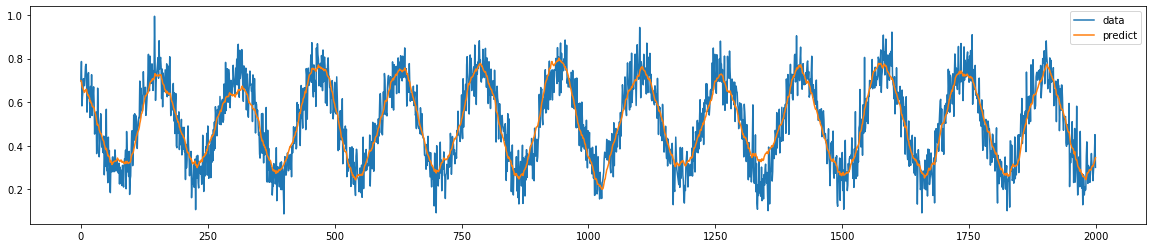

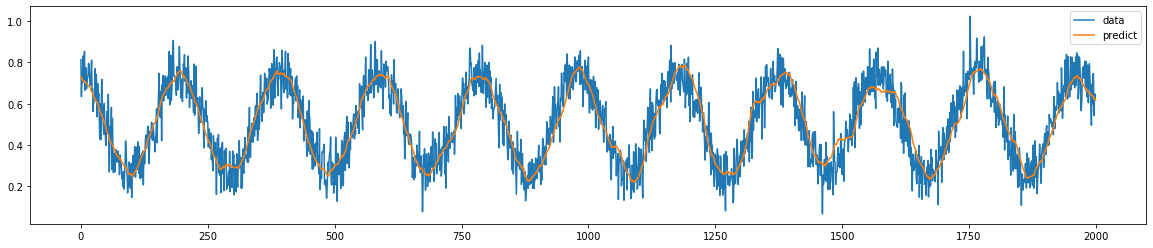

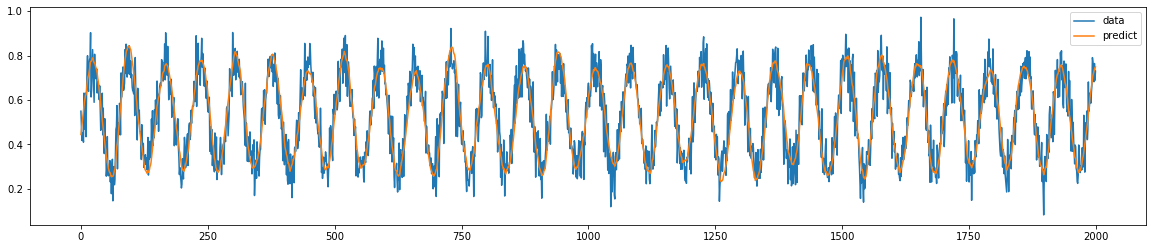

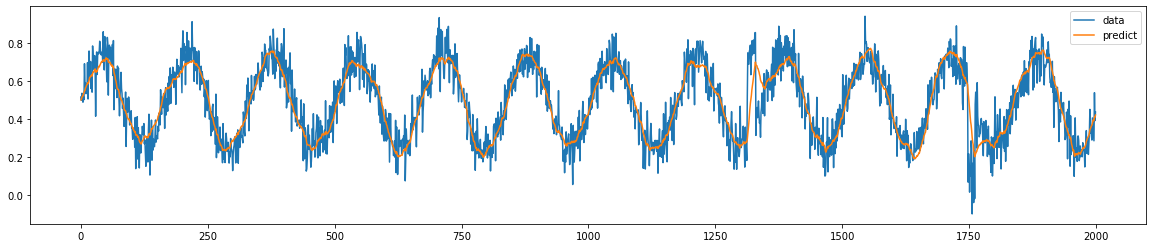

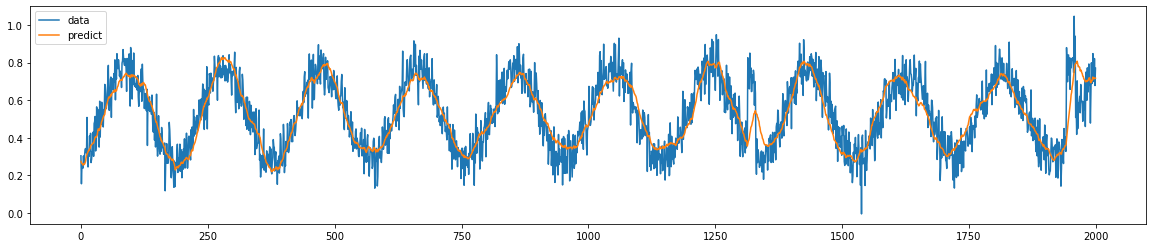

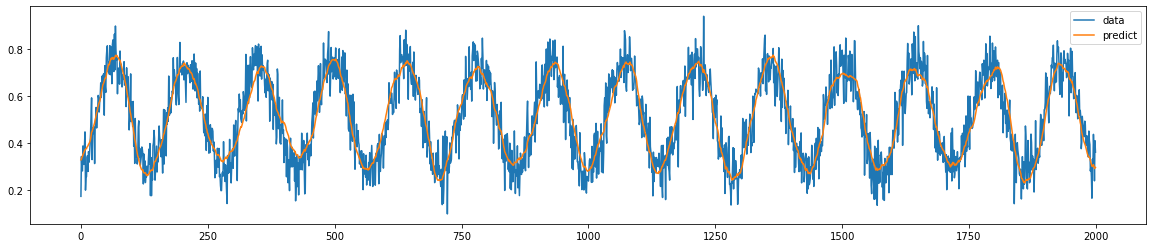

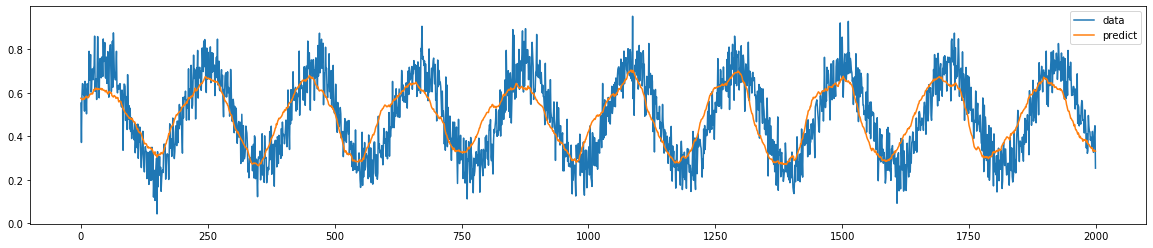

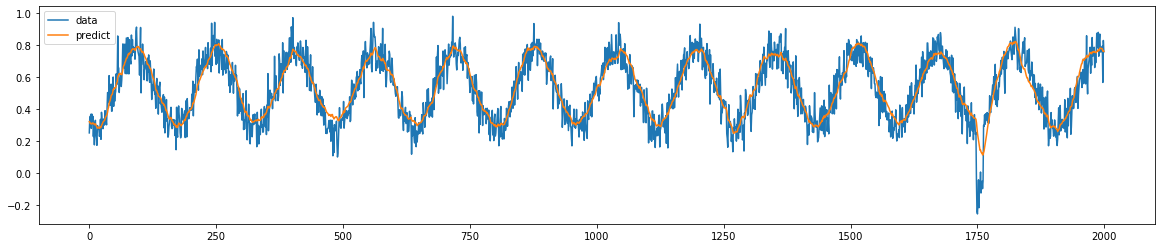

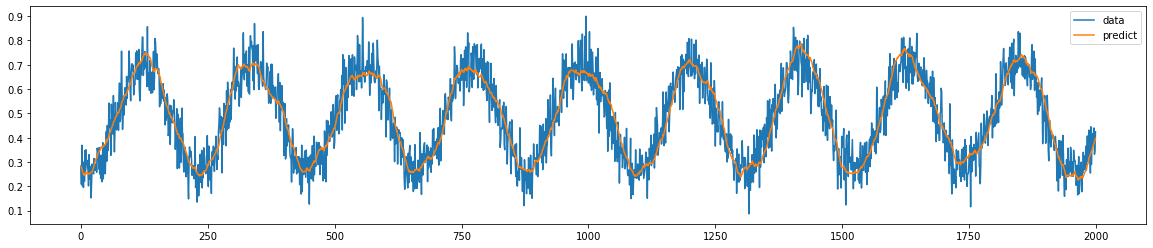

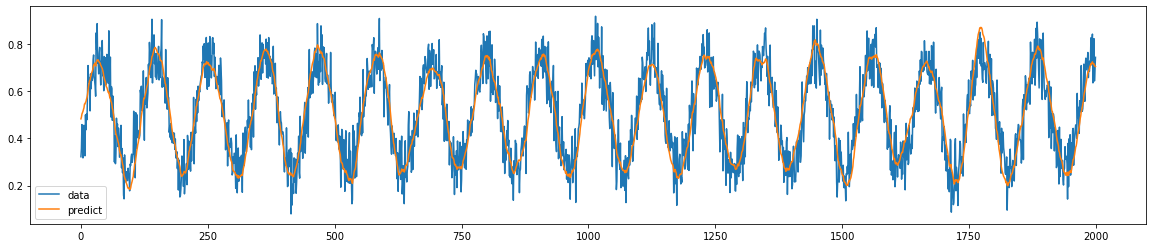

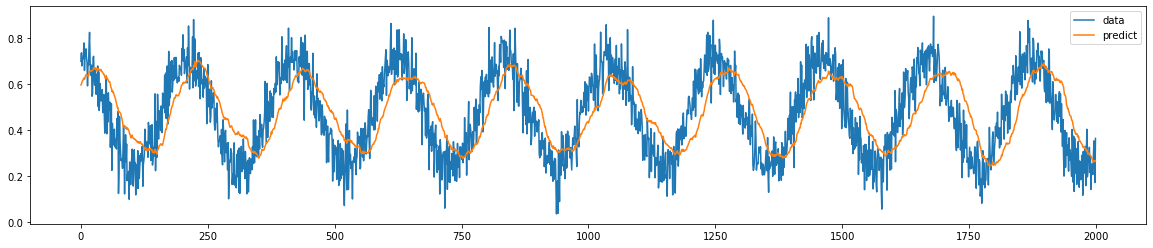

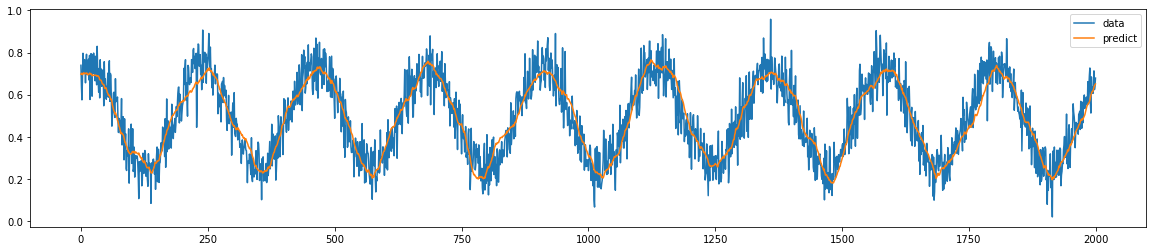

In [145]:
time_window_idx=-1
num_data_points=2000
for i in range(0, x_test_timeseries.shape[-1]):  # plot each feature in a separate plot
    plt.figure(figsize=(20, 4))
    plt.plot(x_test_timeseries[:, time_window_idx, i][:num_data_points], label='data')
    plt.plot(x_test_pred[:, time_window_idx, i][:num_data_points], label='predict')
    plt.legend()
    plt.show()

### DSVAE-AD - Disentangled Sequential Variational Autoencoder Based Anomaly Detector - Proposed method

In [10]:
# models
import tensorflow as tf
from anomaly_detection.models import DSVAE_AD
# training
from anomaly_detection.utils.annealing_callback import AnnealingCallback
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

Split training data into train (70%) and validation (30%).

In [11]:
from sklearn.model_selection import train_test_split
x_train_split, x_valid_split, y_train_split, y_valid_split = train_test_split(x_train, y_train, shuffle=False, test_size=0.3)

Store input dimension into a variable, set time steps and batch size

In [12]:
input_dim = x_train.shape[-1]
n_timesteps = 100
batch_size = 256

Shape the data for the model

In [13]:
from anomaly_detection.utils.timeseries import timeseries_dataset_from_series

x_train_split = tf.cast(x_train_split, tf.keras.backend.floatx())
y_train_split = tf.cast(y_train_split, tf.keras.backend.floatx())
x_valid_split = tf.cast(x_valid_split, tf.keras.backend.floatx())
y_valid_split = tf.cast(y_valid_split, tf.keras.backend.floatx())

train_ds = timeseries_dataset_from_series(
    x_train_split,
    None,
    n_timesteps,
    batch_size,
    shuffle=True,
    shuffle_buffer_size=len(x_train_split))

valid_ds = timeseries_dataset_from_series(
    x_valid_split,
    None,
    n_timesteps,
    batch_size,
    shuffle=False)

Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 100, 20)]    0                                            
__________________________________________________________________________________________________
gru_54 (GRU)                    (None, 100, 128)     57600       encoder_input[0][0]              
__________________________________________________________________________________________________
gru_55 (GRU)                    (None, 128)          57600       encoder_input[0][0]              
__________________________________________________________________________________________________
time_distributed_73 (TimeDistri (None, 100, 3)       387         gru_54[0][0]                     
________________________________________________________________________________________________

    109/Unknown - 3s 32ms/step - loss: 18.8419 - NLL: -96.9209 - KL: 115.8196- 3s 32ms/step - loss: 82.6871 - NLL: -33.1451 - KL: 11 - KL weight: 1.0
109/109 [==============================] - 6s 60ms/step - loss: 18.8419 - NLL: -96.9209 - KL: 115.8196 - val_loss: -506.3927 - val_NLL: -621.0477 - val_KL: 114.2810
Epoch 2/200
109/109 [==============================] - 5s 48ms/step - loss: -585.2947 - NLL: -701.5018 - KL: 116.2129 - val_loss: -580.3566 - val_NLL: -699.0209 - val_KL: 118.4144
Epoch 3/200
109/109 [==============================] - 5s 47ms/step - loss: -694.1838 - NLL: -819.4527 - KL: 125.2752 - val_loss: -693.6858 - val_NLL: -824.1317 - val_KL: 130.2983
Epoch 4/200
109/109 [==============================] - 5s 48ms/step - loss: -814.1775 - NLL: -956.4376 - KL: 142.2677 - val_loss: -809.8663 - val_NLL: -960.8633 - val_KL: 150.9778
Epoch 5/200
109/109 [==============================] - 5s 48ms/step - loss: -938.5087 - NLL: -1102.4690 - KL: 163.9664 - val_loss: -921.9730 - va

Epoch 28/200
109/109 [==============================] - 5s 50ms/step - loss: -1830.4454 - NLL: -2056.4292 - KL: 225.9856 - val_loss: -1718.7781 - val_NLL: -1943.0327 - val_KL: 223.8123
Epoch 29/200
109/109 [==============================] - 5s 49ms/step - loss: -1842.3210 - NLL: -2066.6411 - KL: 224.3220 - val_loss: -1736.0492 - val_NLL: -1959.6140 - val_KL: 223.1105
Epoch 30/200
109/109 [==============================] - 5s 50ms/step - loss: -1855.2870 - NLL: -2077.3672 - KL: 222.0801 - val_loss: -1744.7350 - val_NLL: -1963.1207 - val_KL: 217.9835
Epoch 31/200
109/109 [==============================] - 5s 49ms/step - loss: -1864.0813 - NLL: -2083.5542 - KL: 219.4734 - val_loss: -1762.9578 - val_NLL: -1981.2625 - val_KL: 217.8309
Epoch 32/200
109/109 [==============================] - 5s 49ms/step - loss: -1871.8435 - NLL: -2088.9736 - KL: 217.1317 - val_loss: -1766.7087 - val_NLL: -1982.7972 - val_KL: 215.8749
Epoch 33/200
109/109 [==============================] - 5s 50ms/step - loss

Epoch 55/200
109/109 [==============================] - 6s 52ms/step - loss: -2112.3425 - NLL: -2306.0007 - KL: 193.6593 - val_loss: -2078.1350 - val_NLL: -2269.6135 - val_KL: 191.6162
Epoch 56/200
109/109 [==============================] - 5s 49ms/step - loss: -2123.2742 - NLL: -2314.6709 - KL: 191.3985 - val_loss: -2078.9958 - val_NLL: -2270.5271 - val_KL: 191.6559
Epoch 57/200
109/109 [==============================] - 5s 49ms/step - loss: -2122.7288 - NLL: -2311.5869 - KL: 188.8582 - val_loss: -2085.2207 - val_NLL: -2275.3977 - val_KL: 190.2781
Epoch 58/200
109/109 [==============================] - 5s 49ms/step - loss: -2132.8357 - NLL: -2319.9607 - KL: 187.1242 - val_loss: -2100.9878 - val_NLL: -2288.3694 - val_KL: 187.4135
Epoch 59/200
109/109 [==============================] - 5s 49ms/step - loss: -2136.6726 - NLL: -2321.7454 - KL: 185.0733 - val_loss: -2102.5955 - val_NLL: -2287.7954 - val_KL: 185.2924
Epoch 60/200
109/109 [==============================] - 5s 49ms/step - loss

Epoch 82/200
109/109 [==============================] - 6s 55ms/step - loss: -2216.1570 - NLL: -2359.9966 - KL: 143.8392 - val_loss: -2182.7988 - val_NLL: -2325.3401 - val_KL: 142.7003
Epoch 83/200
109/109 [==============================] - 6s 52ms/step - loss: -2220.5398 - NLL: -2363.0098 - KL: 142.4697 - val_loss: -2184.1904 - val_NLL: -2325.7964 - val_KL: 141.7811
Epoch 84/200
109/109 [==============================] - 6s 52ms/step - loss: -2225.0242 - NLL: -2365.0535 - KL: 140.0302 - val_loss: -2193.9946 - val_NLL: -2331.6089 - val_KL: 137.8451
Epoch 85/200
109/109 [==============================] - 6s 51ms/step - loss: -2232.8184 - NLL: -2368.3630 - KL: 135.5457 - val_loss: -2184.5159 - val_NLL: -2318.1328 - val_KL: 133.7083
Epoch 86/200
109/109 [==============================] - 6s 51ms/step - loss: -2237.9541 - NLL: -2370.4131 - KL: 132.4590 - val_loss: -2202.6785 - val_NLL: -2334.4812 - val_KL: 131.9123
Epoch 87/200
109/109 [==============================] - 5s 50ms/step - loss

Epoch 109/200
109/109 [==============================] - 5s 50ms/step - loss: -2266.5718 - NLL: -2389.4878 - KL: 122.9162 - val_loss: -2223.4189 - val_NLL: -2346.5100 - val_KL: 123.2853
Epoch 110/200
109/109 [==============================] - 5s 49ms/step - loss: -2266.3853 - NLL: -2388.9653 - KL: 122.5798 - val_loss: -2230.6396 - val_NLL: -2353.3457 - val_KL: 122.8571
Epoch 111/200
109/109 [==============================] - 5s 50ms/step - loss: -2268.5220 - NLL: -2390.9412 - KL: 122.4183 - val_loss: -2226.3108 - val_NLL: -2348.8875 - val_KL: 122.7659
Epoch 112/200
109/109 [==============================] - 5s 50ms/step - loss: -2267.5764 - NLL: -2389.7373 - KL: 122.1608 - val_loss: -2222.0496 - val_NLL: -2344.3701 - val_KL: 122.4546
Epoch 113/200
109/109 [==============================] - 5s 49ms/step - loss: -2268.4707 - NLL: -2390.3743 - KL: 121.9021 - val_loss: -2226.4309 - val_NLL: -2348.2483 - val_KL: 122.0471
Epoch 114/200
109/109 [==============================] - 5s 49ms/step 

Epoch 136/200
109/109 [==============================] - 5s 48ms/step - loss: -2278.3057 - NLL: -2396.6401 - KL: 118.3355 - val_loss: -2240.0828 - val_NLL: -2358.4451 - val_KL: 118.5289
Epoch 137/200
109/109 [==============================] - 5s 50ms/step - loss: -2280.4883 - NLL: -2398.8027 - KL: 118.3145 - val_loss: -2242.9558 - val_NLL: -2361.2034 - val_KL: 118.4147
Epoch 138/200
109/109 [==============================] - 5s 49ms/step - loss: -2279.9963 - NLL: -2398.2261 - KL: 118.2291 - val_loss: -2238.9954 - val_NLL: -2357.4644 - val_KL: 118.6529
Epoch 139/200
109/109 [==============================] - 5s 48ms/step - loss: -2280.1921 - NLL: -2398.3750 - KL: 118.1832 - val_loss: -2239.9216 - val_NLL: -2358.1575 - val_KL: 118.3173
Epoch 140/200
109/109 [==============================] - 5s 48ms/step - loss: -2280.3115 - NLL: -2398.3752 - KL: 118.0633 - val_loss: -2240.0518 - val_NLL: -2357.9688 - val_KL: 118.0885
Epoch 141/200
109/109 [==============================] - 5s 48ms/step 

Epoch 163/200
109/109 [==============================] - 5s 49ms/step - loss: -2284.5754 - NLL: -2401.0317 - KL: 116.4560 - val_loss: -2244.5654 - val_NLL: -2360.9822 - val_KL: 116.6757
Epoch 164/200
109/109 [==============================] - 5s 49ms/step - loss: -2286.7031 - NLL: -2403.2031 - KL: 116.5001 - val_loss: -2248.1177 - val_NLL: -2364.8933 - val_KL: 116.9668
Epoch 165/200
109/109 [==============================] - 5s 48ms/step - loss: -2286.2197 - NLL: -2402.7339 - KL: 116.5147 - val_loss: -2241.8735 - val_NLL: -2358.7114 - val_KL: 117.0245
Epoch 166/200
109/109 [==============================] - 5s 48ms/step - loss: -2285.9648 - NLL: -2402.2649 - KL: 116.3006 - val_loss: -2245.0278 - val_NLL: -2361.6741 - val_KL: 116.7821
Epoch 167/200
109/109 [==============================] - 6s 50ms/step - loss: -2286.4167 - NLL: -2402.7439 - KL: 116.3277 - val_loss: -2249.7722 - val_NLL: -2366.0332 - val_KL: 116.4786
Epoch 168/200
109/109 [==============================] - 5s 48ms/step 

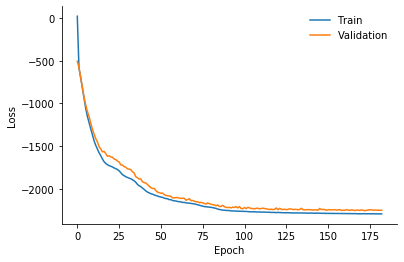

t {'f1-score': 0.8266666145422251, 'precision': 0.8611111087191358, 'recall': 0.794871792833662, 'TP': 31, 'TN': 35636, 'FP': 5, 'FN': 8, 'detection_latency': 32.06451602559834}
th -6.547465896606084
HitRate@100%: 0.9516129032258065
HitRate@150%: 0.9516129032258065


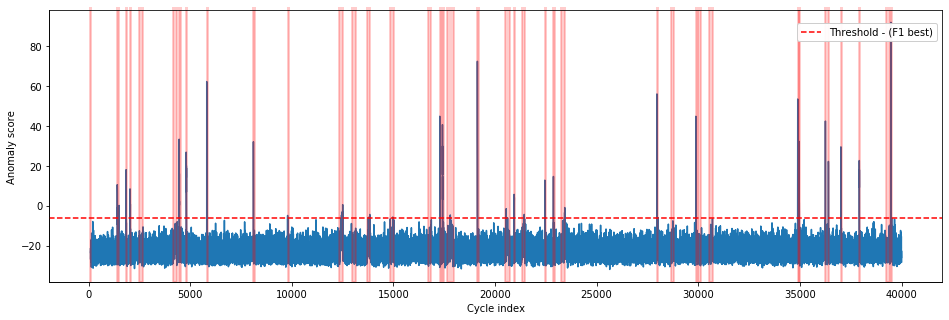

In [24]:
# the starting value of KL weight
kl_anneal_weight = K.variable(value=1)
kl_anneal_weight._trainable = False  # It isn't trained. We set it explicitly with the callback.
# The epochs at which KL loss starts to be increased (if less than 1 initially)
kl_start = 1
# number of epochs over which KL scaling is increased from 0 to 1
kl_annealtime = 1

model = DSVAE_AD(input_dim,
    timesteps=n_timesteps,
    rnn_num_hidden=128,
    dense_dim=128,
    latent_dim=3,
    latent_dim_static=80,
    use_static_encoder=True,
    kl_anneal_weight=kl_anneal_weight,
    rnn_layer='GRU',
    bidirectional=False,
    nf_layers=0,
    noise_stddev=None,
    allow_cudnn_kernel=True,
    use_connected_z_p=False,
    use_connected_z_q=False,
    weight_regularizer=None,
    n_samples_train=1,
    n_samples_predict=64,
    optimizer=tf.keras.optimizers.Adam(clipnorm=10.0))

# print model architecture
print(model.model.summary())

# callbacks
# stop training when there is no improvement in the validation loss for 5 consecutive epochs
es_cb = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)
kl_anneal_cb = AnnealingCallback(kl_start, kl_annealtime, kl_anneal_weight)
checkpoint_filepath = './checkpoints/checkpoint_dsvae_artificial_final'
mc_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)
cb_list = [kl_anneal_cb, es_cb, mc_cb]

# fit model on the training data
history = model.fit(train_ds, validation_data=valid_ds, epochs=200, callbacks=cb_list)

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right', frameon=False)
plt.savefig('artificial_training_loss_final.pdf', bbox_inches='tight')
plt.show()

# use small enough batch size to prevent OOM
x_test_feature_scores = model.get_anomaly_score(x_test, batch_size=1, sum_datapoint_dimensions=False)
x_test_scores = np.sum(x_test_feature_scores, axis=-1)
best_threshold = find_best_f1_score(y_test, x_test_scores, threshold_search_step_size=0.05, threshold_search_end=np.percentile(x_test_scores, 99.95), single_score_per_labeled_sequence=True, skip_n_first=skip_n_first)
# anomaly interpretation performance
y_test_pred_best = (x_test_scores > best_threshold).astype(int)
print('HitRate@100%:', get_anomaly_root_cause_hitrate_perf_v2(y_test, y_test_pred_best, x_test_scores, x_test_feature_scores, y_test_root_causes, p=100))
print('HitRate@150%:', get_anomaly_root_cause_hitrate_perf_v2(y_test, y_test_pred_best, x_test_scores, x_test_feature_scores, y_test_root_causes, p=150))
# plot anomaly scores
plot_anomaly_scores(x_test_scores, y_test, best_threshold)

#### Load existing model weights from file

In [27]:
# the starting value of KL weight
kl_anneal_weight = K.variable(value=1)
kl_anneal_weight._trainable = False  # It isn't trained. We set it explicitly with the callback.
# The epochs at which KL loss starts to be increased (if less than 1 initially)
kl_start = 1
# number of epochs over which KL scaling is increased from 0 to 1
kl_annealtime = 1

model = DSVAE_AD(input_dim,
    timesteps=n_timesteps,
    rnn_num_hidden=128,
    dense_dim=128,
    latent_dim=3,
    latent_dim_static=80,
    use_static_encoder=True,
    kl_anneal_weight=kl_anneal_weight,
    rnn_layer='GRU',
    bidirectional=False,
    nf_layers=0,
    noise_stddev=None,
    allow_cudnn_kernel=True,
    use_connected_z_p=False,
    use_connected_z_q=False,
    weight_regularizer=None,
    n_samples_train=1,
    n_samples_predict=32,
    optimizer=tf.keras.optimizers.Adam(clipnorm=10.0))

# load existing weights
model.model.load_weights('./checkpoints/checkpoint_dsvae_artificial_final')
model._model_pred.set_weights(model.model.get_weights())

#### Evaluate the anomaly detection and root cause intepretation performance

t {'f1-score': 0.8266666145422251, 'precision': 0.8611111087191358, 'recall': 0.794871792833662, 'TP': 31, 'TN': 35636, 'FP': 5, 'FN': 8, 'detection_latency': 32.06451602559834}
th -6.547465896606084
HitRate@100%: 0.9516129032258065
HitRate@150%: 0.9516129032258065


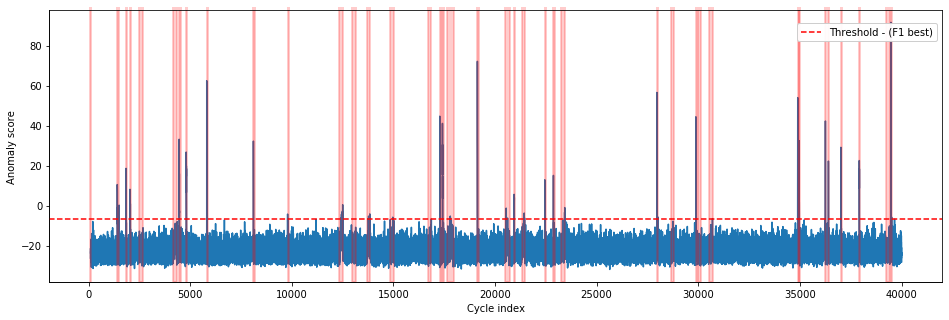

In [28]:
# use small enough batch size to prevent OOM
x_test_feature_scores = model.get_anomaly_score(x_test, batch_size=1, sum_datapoint_dimensions=False)
x_test_scores = np.sum(x_test_feature_scores, axis=-1)
best_threshold = find_best_f1_score(y_test, x_test_scores, threshold_search_step_size=0.05, threshold_search_end=np.percentile(x_test_scores, 99.95), single_score_per_labeled_sequence=True, skip_n_first=skip_n_first)
# anomaly interpretation performance
y_test_pred_best = (x_test_scores > best_threshold).astype(int)
print('HitRate@100%:', get_anomaly_root_cause_hitrate_perf_v2(y_test, y_test_pred_best, x_test_scores, x_test_feature_scores, y_test_root_causes, p=100))
print('HitRate@150%:', get_anomaly_root_cause_hitrate_perf_v2(y_test, y_test_pred_best, x_test_scores, x_test_feature_scores, y_test_root_causes, p=150))
# plot anomaly scores
plot_anomaly_scores(x_test_scores, y_test, best_threshold)

#### Measure avg time to score single sample

In [41]:
x_test_timeseries = get_timeseries_from_array(x_test, n_timesteps)
%timeit model.get_anomaly_score(x_test_timeseries[0], batch_size=1, sum_datapoint_dimensions=False)

127 ms ± 7.52 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [42]:
x_test_timeseries = get_timeseries_from_array(x_test, n_timesteps)
%timeit model.get_anomaly_score(x_test_timeseries[0], batch_size=1, sum_datapoint_dimensions=False)

111 ms ± 4.68 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### Visualize reconstructions

(39901, 100, 20)


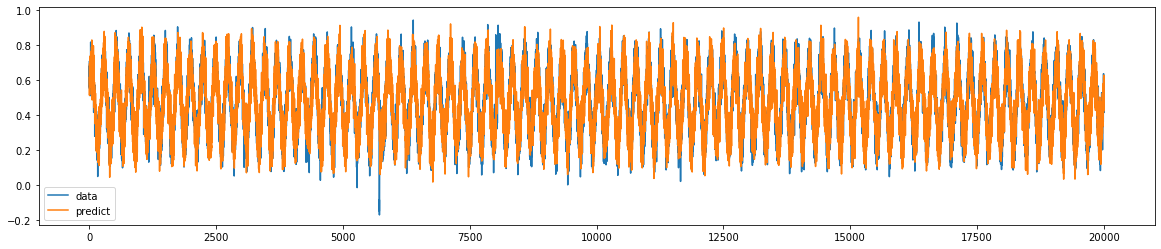

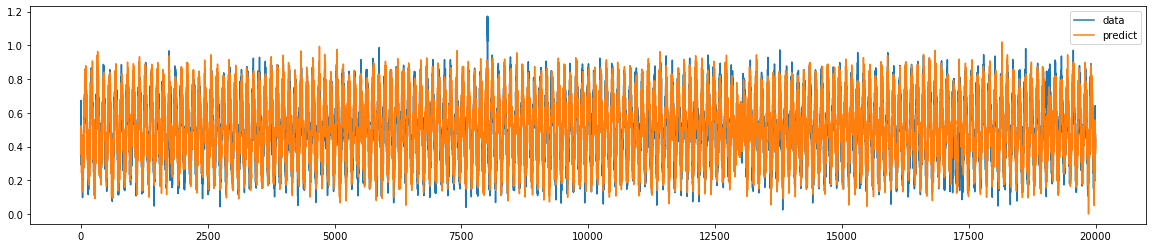

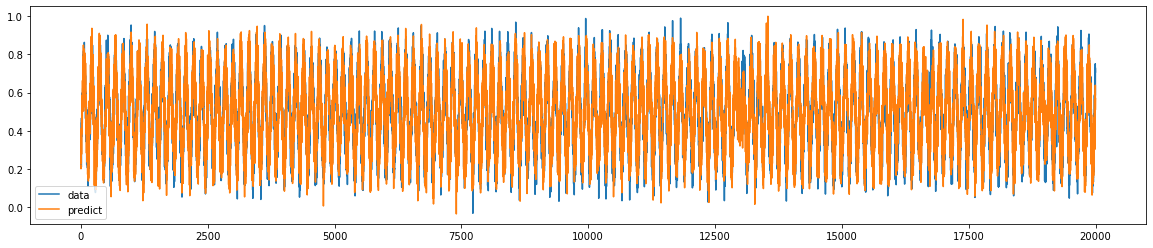

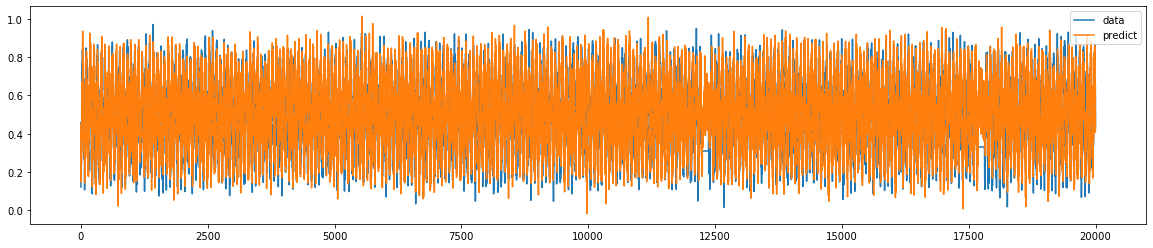

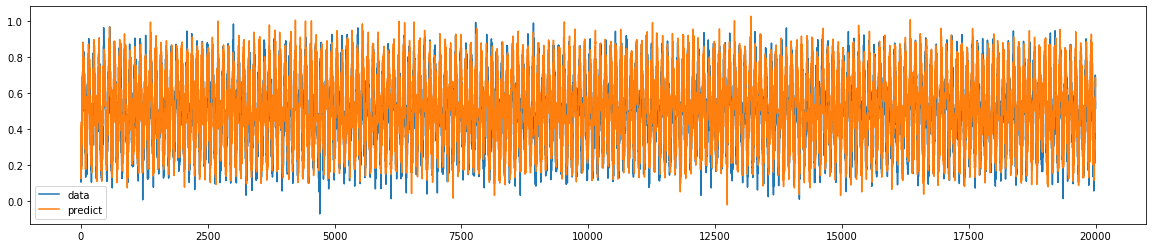

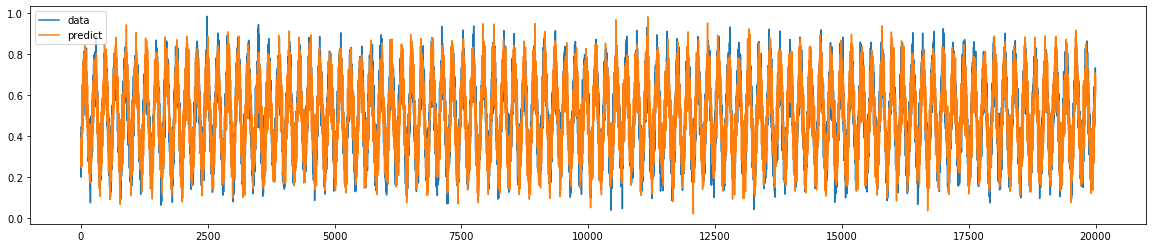

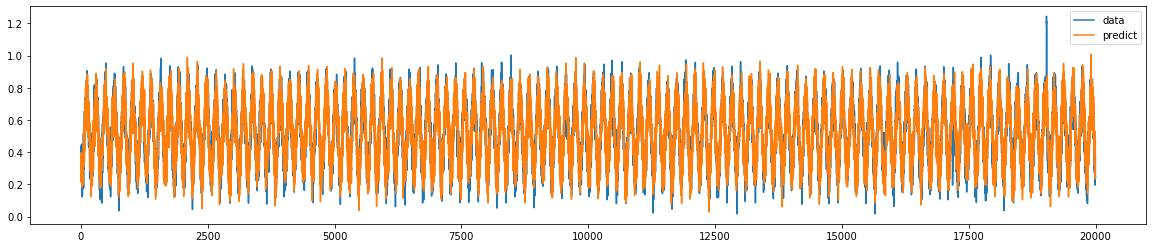

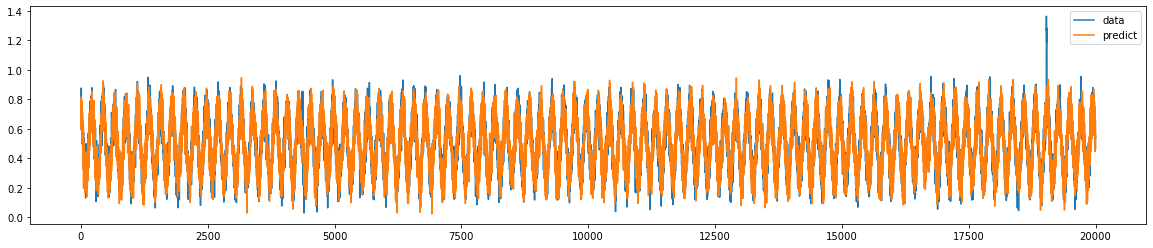

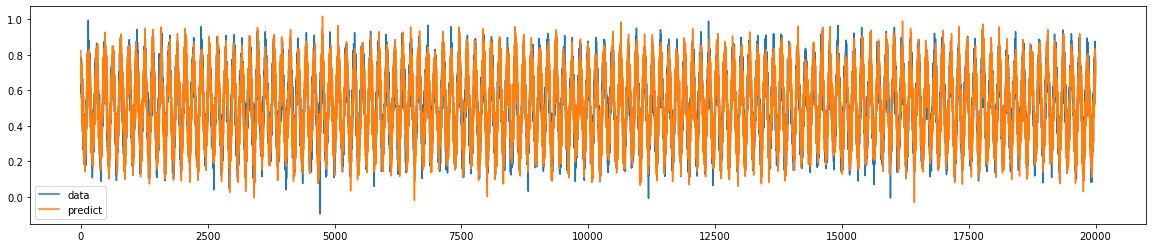

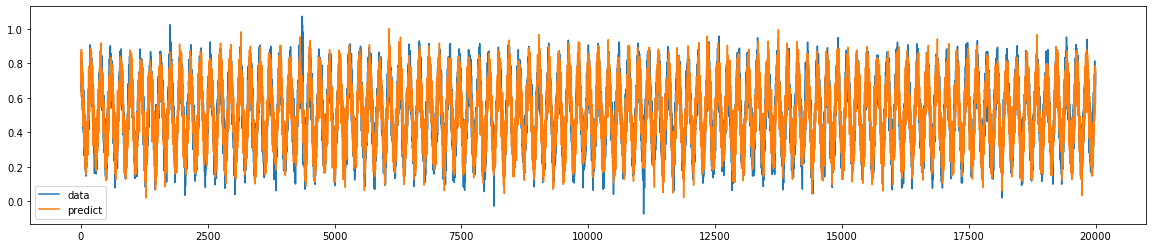

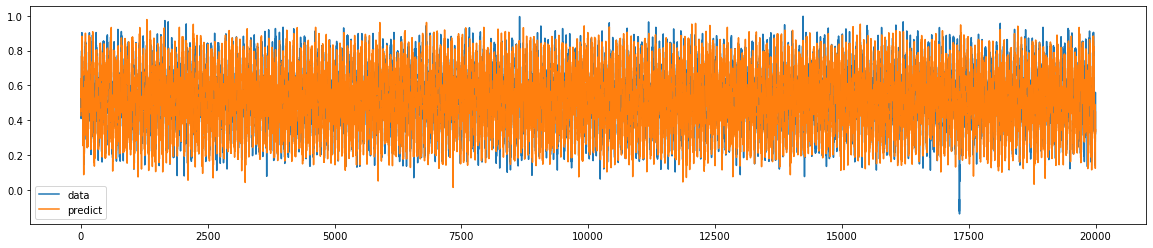

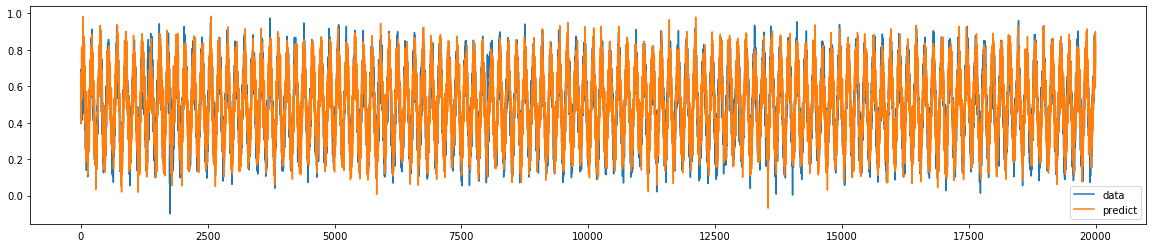

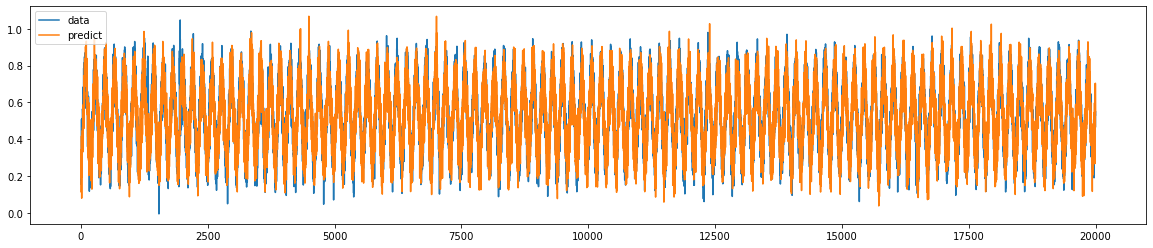

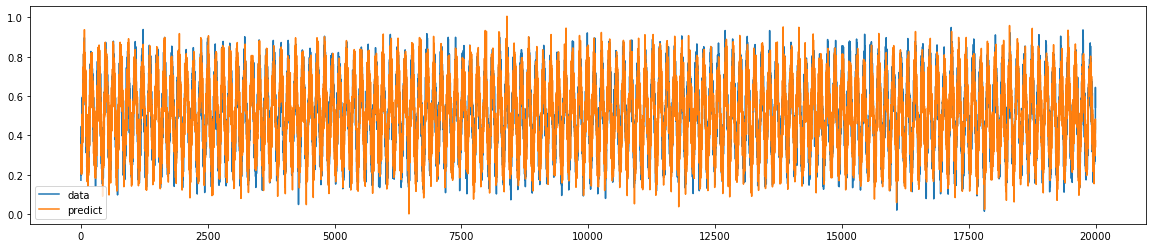

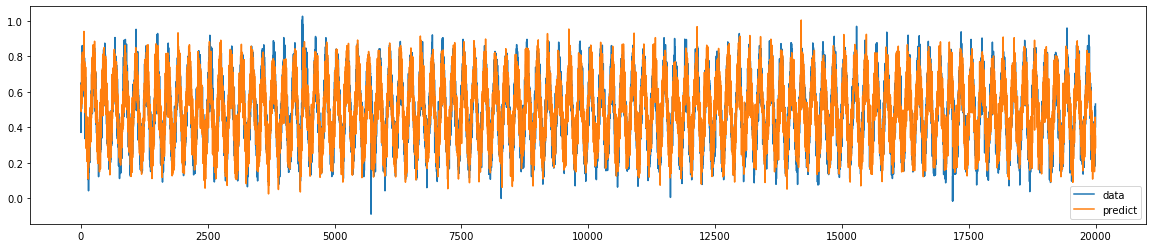

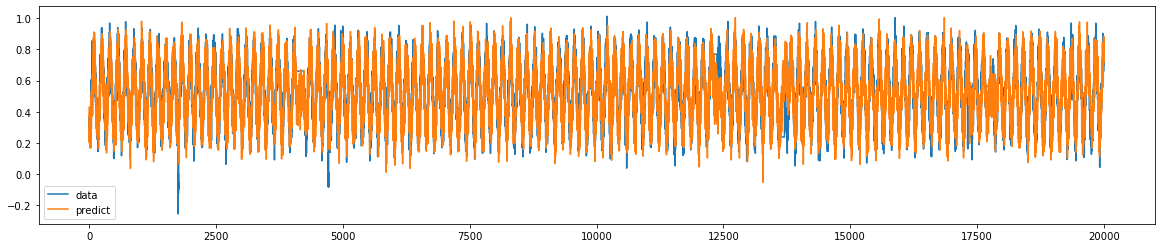

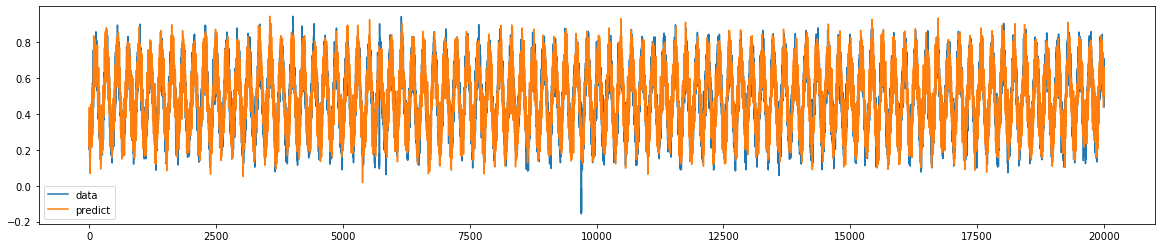

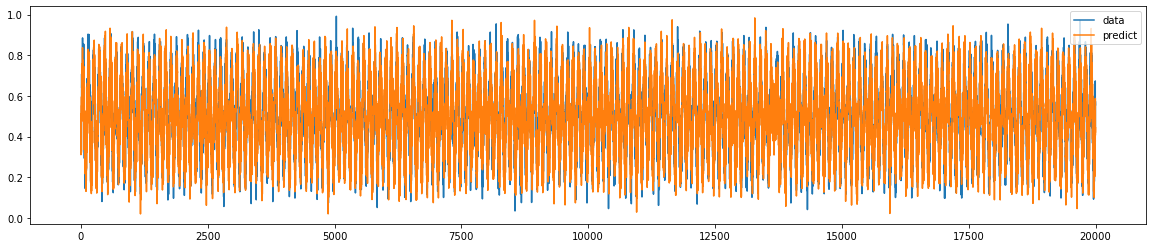

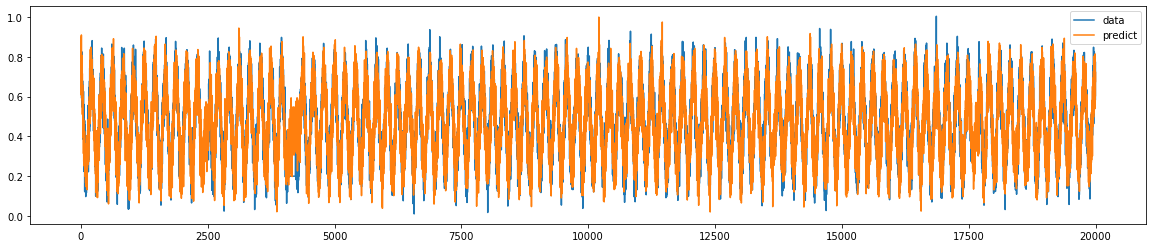

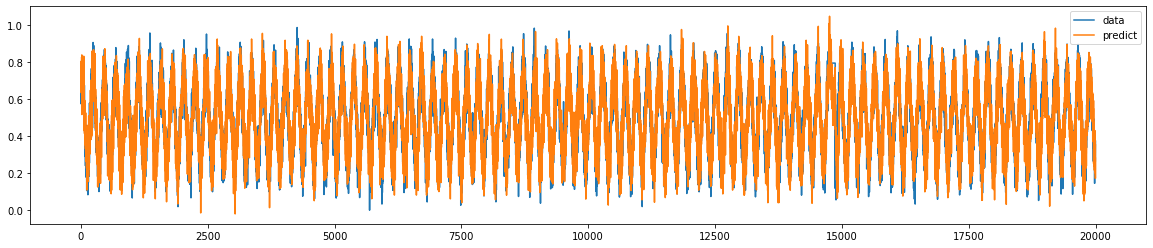

In [39]:
timesteps = n_timesteps
x_test_timeseries = get_timeseries_from_array(x_test, timesteps)
print(x_test_timeseries.shape)
x_test_pred = model.predict(x_test_timeseries, batch_size=batch_size)
time_window_idx=-1
num_data_points=20000
for i in range(0, x_test_timeseries.shape[-1]):  # plot each feature in a separate plot
    plt.figure(figsize=(20, 4))
    plt.plot(x_test_timeseries[:, time_window_idx, i][:num_data_points], label='data')
    plt.plot(x_test_pred[:, time_window_idx, i][:num_data_points], label='predict')
    plt.legend()
    plt.show()

#### Test choosing anomaly threshold using POT method

In [43]:
x_train_anomaly_scores = model.get_anomaly_score(x_train, batch_size=8)

In [58]:
from anomaly_detection.utils.metrics import get_perf_metrics_for_anomaly_scores
from anomaly_detection.models.spot.spot import SPOT
q=0.00005
level=0.98 # 0.98
print(q)
spot = SPOT(q)
spot.fit(x_train_anomaly_scores, []) # import data to SPOT
spot.initialize(level=level) # run the calibration (initialization) step, i.e. the POT algorithm
spot_threshold = spot.extreme_quantile
print('spot_threshold', spot_threshold)
get_perf_metrics_for_anomaly_scores(y_test[-len(x_test_scores):], x_test_scores, spot_threshold, single_score_per_labeled_sequence=True)

5e-05
Initial threshold : -16.309881
Number of peaks : 798
Grimshaw maximum log-likelihood estimation ... [done]
	γ = 0
	σ = 1.7425447
	L = 1241.1664974395585
Extreme quantile (probability = 5e-05): -5.869530384170304
spot_threshold -5.869530384170304


{'f1-score': 0.8219177562019169,
 'precision': 0.8823529385813148,
 'recall': 0.7692307672583826,
 'TP': 30,
 'TN': 35638,
 'FP': 4,
 'FN': 9,
 'detection_latency': 28.033333239888886}